In [2]:
from transformers import GPT2Tokenizer
from sae_lens import HookedSAETransformer
import torch
from torch.nn.functional import cosine_similarity
import matplotlib.pyplot as plt
import datasets
from collections import defaultdict

In [3]:
device='cuda'
transformer_name = 'gpt2-small'


In [4]:
transformer = HookedSAETransformer.from_pretrained(transformer_name, device=device)
tok = transformer.tokenizer
hook_name = 'blocks.9.hook_resid_pre'
layer=10

Loaded pretrained model gpt2-small into HookedTransformer


In [40]:
data = datasets.load_dataset('NeelNanda/pile-10k')['train']
n_texts = 100
texts = []

for i, t in enumerate(data):
    if len(t['text']) > 5000:
        texts.append(t['text'])


    if len(texts) == n_texts:
        break

print('went through', i, 'texts')

went through 562 texts


In [41]:
input = tok(texts, padding=True, truncation=True, return_tensors='pt', max_length=1024)
print(torch.mean(input.attention_mask.to(torch.float32), dim=1))
assert torch.all(torch.mean(input.attention_mask.to(torch.float32), dim=1) == 1)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


In [42]:
sequence_acts = []

with torch.no_grad():
    for i in range(n_texts):
        sequence_acts.append(
            transformer.run_with_cache(input.input_ids[i].to(device), prepend_bos=False, stop_at_layer=layer)[1][hook_name]
        )



In [44]:
def generate_activations(transformer, all_tokens, t_fn, batch_size=32):
    all_tokens = list(all_tokens)
    sequences = []

    for t in all_tokens:
        sequences.append(t_fn(t))

    t_acts = None
    for i in range(0, len(sequences), batch_size):
        batch = sequences[i:i+batch_size]
        ids = torch.tensor(batch, device=device)

        _, activations = transformer.run_with_cache(ids, prepend_bos=False, stop_at_layer=layer)
        activations = activations[hook_name]
        if t_acts is None:
            t_acts = activations[:, -1, :].to('cpu')
        else:
            t_acts = torch.concat((t_acts, activations[:, -1, :].to('cpu')), dim=0)

    act_dict = {}

    for i, act in enumerate(t_acts):
        act_dict[all_tokens[i]] = act

    return act_dict
    
    

In [46]:
all_tokens = set()

for i in range(n_texts):
    all_tokens.update(input.input_ids[i].tolist())

bos = generate_activations(transformer, all_tokens, lambda t: [tok.bos_token_id, t])
repeat = generate_activations(transformer, all_tokens, lambda t: [t, t])
space = generate_activations(transformer, all_tokens, lambda t: [220, t])
newline = generate_activations(transformer, all_tokens, lambda t: [198, t])
space2 = generate_activations(transformer, all_tokens, lambda t: [220, 220, t])


In [47]:
def get_correlations(sequence_acts, input_ids, act_dict, device):
    cos = []

    for i, id in enumerate(input_ids):
        act = act_dict[int(id)].to(device)
        cos.append(
            cosine_similarity(sequence_acts[i].unsqueeze(0), act.unsqueeze(0)).cpu().item()
        )

    return torch.tensor(cos)

In [50]:
corrs = defaultdict(list)

for i in range(n_texts):
    sa = sequence_acts[i].squeeze()
    input_ids = input.input_ids[i]

    corrs['bos'].append(get_correlations(sa, input_ids, bos, device))
    corrs['repeat'].append(get_correlations(sa, input_ids, repeat, device))
    corrs['space'].append(get_correlations(sa, input_ids, space, device))
    corrs['newline'].append(get_correlations(sa, input_ids, newline, device))
    corrs['space2'].append(get_correlations(sa, input_ids, space2, device))



bos torch.Size([1024]) tensor(0.6035) tensor(0.0497)
repeat torch.Size([1024]) tensor(0.6241) tensor(0.0482)
space torch.Size([1024]) tensor(0.6256) tensor(0.0477)
newline torch.Size([1024]) tensor(0.6152) tensor(0.0487)
space2 torch.Size([1024]) tensor(0.6198) tensor(0.0475)


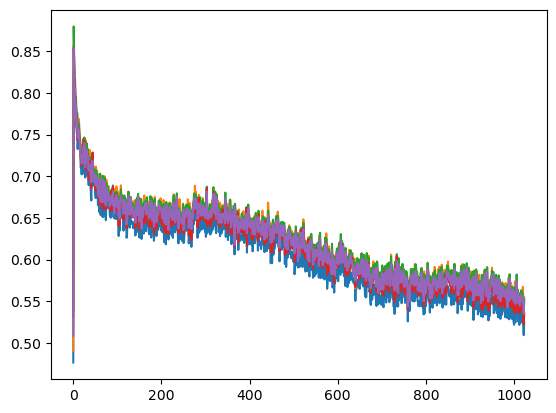

In [51]:
for k, v in corrs.items():
    s = torch.stack(v).mean(dim=0)
    print(k, s.shape, s.mean(), s.std())
    plt.plot(s, label=k)